In [2]:
import warnings
warnings.filterwarnings('ignore')

from fredapi import Fred
import quandl

import datetime
from datetime import date, timedelta

import utils
import numpy as np
from math import sqrt # for RMSE
import pandas as pd
import scipy
import statsmodels.api as sm

from fbprophet import Prophet # for forecasting via ML called "Prophet"
from fbprophet.plot import plot_plotly
import logging
logging.getLogger().setLevel(logging.ERROR) # mutes unimportant diagnostic messages

import sklearn.decomposition as sck_dec # has PCA functionalities
import sklearn.decomposition.pca as PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler # for standardizing the Data
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
#import pmdarima as pm # auto arima


from pandas import DataFrame
import matplotlib
from matplotlib import pyplot
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
matplotlib.style.use('ggplot')
%matplotlib inline
import matplotlib.pyplot as plt


# standardizes the size of all plots, rather than typing plot(figsize = (12,6)) everytime
from pylab import rcParams
rcParams['figure.figsize'] = 12,6 

import seaborn as sns
from plotly import __version__ 
import cufflinks as cf 
from IPython.display import display, HTML, Image
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go

# set plotly to offline mode for easy reproducibilty
import plotly.offline as py
py.init_notebook_mode()


from statsmodels.tsa.stattools import adfuller,grangercausalitytests
from statsmodels.tsa.stattools import ccovf,ccf,periodogram
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR

quandl.ApiConfig.api_key = '-kesKc4A8jkkBwyX3rSX'
fred = Fred(api_key='7e70df3f020852ea824275ce0fea70a0')

ModuleNotFoundError: No module named 'utils'

In [18]:
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

week = ["FRED/CCSA", # UI claims - weekly;                                              Jan 1, 1967 to June 13,2020
    
    "FRED/WALCL", # Total Assets (Less Eliminations From Consolidation) - weekly;     Dec 16, 2002 - June 24,2020
    
    "FRED/RPONTSYD"] # Overnight Repurchase Agreements: Treasury Securities Purchased by Fed in OMO - weekly
                                                                                       # July 3,2000 to July 1,2020
    

In [19]:
daily = ["FRED/TEDRATE",  # TED Spread - daily ;                                    Jan 1, 1986 to June 24,2020
    
    "FRED/THREEFF1" , # Fitted Instantaneous Forward Rate 1 Year Hence - daily;         Jan 1,1990 to June 19,2020
    
    "FRED/USRECD", # NBER based recession indicator - daily                            July 1854 to June 30, 2020
    
    "FRED/T1YFF" , # 1-Year Treasury Constant Maturity Minus Federal Funds Rate        Jan 1, 1962 to June 30,2020
    
    "FRED/THREEFYTP10" , # Term Premium on a 10 Year Zero Coupon Bond - daily         Jan 1,1990 to June 26,2020
    
    "FRED/T10Y3M"]  # 10 year treasury constant maturity - 3 month tres cons mat       Jan 4, 1982 to July 2,2020



yieldd = quandl.get(daily, start_date = "1990-01-01", end_date="2020-07-02", collapse = 'daily',date_parser=parser)
yieldd.columns = ['ted', 
                  'forward1yr',
                  'rec_ind',
                  '1yr-ffr',
                  'termpr',
                  'yieldsp']

   
yieldd.tail()

,ted,forward1yr,rec_ind,1yr-ffr,termpr,yieldsp
Date,,,,,,
2020-06-28,NaN,NaN,1.0,NaN,NaN,NaN
2020-06-29,0.16,0.2140,1.0,0.08,-0.8886,0.50
2020-06-30,0.14,0.2177,1.0,0.08,-0.8853,0.50
2020-07-01,0.16,0.2301,1.0,0.08,-0.8709,0.55
2020-07-02,0.16,0.2213,1.0,0.07,-0.8727,0.54


In [20]:
sahm = fred.get_series('SAHMREALTIME',observation_start='1972-01-01', observation_end='2020-07-02', )
sahm_df = sahm.to_frame(name = 'sahm')
sahm_df.index.name = 'Date'

# apply cubic spline interpolation to get daily value of sahm rule from monthly values
upsample = sahm_df['sahm'].resample('D').interpolate(method='cubic').to_frame(name = 'sahm')
upsample.head()

,sahm
Date,
1972-01-01,0.030000
1972-01-02,0.021862
1972-01-03,0.014137
1972-01-04,0.006817
1972-01-05,-0.000109


In [21]:
yield_d = pd.merge(yieldd, upsample, on = 'Date') 
yieldd['vix'] = fred.get_series('VIXCLS', observation_start='1990-01-01', observation_end='2020-07-02')
yield_d = pd.merge(yieldd, upsample, on = 'Date')
yield_d = yield_d.fillna(method='bfill') # use next valid observation to fill gap.
yield_d.head()

,ted,forward1yr,rec_ind,1yr-ffr,termpr,yieldsp,vix,sahm
Date,,,,,,,,
1990-01-01,0.80,7.8401,0.0,-0.73,1.6625,0.11,17.24,0.130000
1990-01-02,0.80,7.8401,0.0,-0.73,1.6625,0.11,17.24,0.130696
1990-01-03,0.75,7.8880,0.0,-0.52,1.6865,0.10,18.19,0.131360
1990-01-04,0.79,7.8773,0.0,-0.47,1.6890,0.14,19.22,0.131991
1990-01-05,0.84,7.8694,0.0,-0.41,1.7017,0.20,20.11,0.132587


In [22]:
yield_d.isnull().sum()

ted           0
forward1yr    0
rec_ind       0
1yr-ffr       0
termpr        0
yieldsp       0
vix           0
sahm          0
dtype: int64

In [23]:
def adfuller_test(series, signif = 0.05, name = '', verbose = False):
    """Perform ADFuller to test for stationarity of a given series and print report"""
    
    r = adfuller(series, autolag = 'AIC')
    output = {'test_statistic': round(r[0], 4), 'pvalue': round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length = 6): return str(val).ljust(length)
    
    # print sumamry
    print(f'     Augmented Dickey-Fuller Test on "{name}"', "\n    ", '-'*47)
    print(f'  Null Hypothesis: Data has unit too. Non-Stationary.')
    print(f'  Significance Level    = {signif}')
    print(f'  Test Statistic        = {output["test_statistic"]}')
    print(f'  No. of Lags Chosen    = {output["n_lags"]}')
          
    for key, val in r[4].items():
          print(f'  Critical Value {adjust(key)} = {round(val, 3)}')
          
    if p_value <= signif:
          print(f" => P-Value = {p_value}. Rejecting null hypothesis.")
          print(f" => Series is stationary.")
    else:
          print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
          print(f" => Series is non-stationary.")
 

In [24]:
data_list = yield_d[list(yield_d.columns)]

#data_list = yield_d[['ffr', 'rec_prob', 'epop', 'rwage', 'sahm', 'rgdp_change', 'house_st_change',
      # 'ipi_change']]

# ADF Test on the levelled (original) values each column
for name, column in data_list.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "ted" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -5.1175
  No. of Lags Chosen    = 39
  Critical Value 1%     = -3.431
  Critical Value 5%     = -2.862
  Critical Value 10%    = -2.567
 => P-Value = 0.0. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "forward1yr" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -1.5283
  No. of Lags Chosen    = 3
  Critical Value 1%     = -3.431
  Critical Value 5%     = -2.862
  Critical Value 10%    = -2.567
 => P-Value = 0.5195. Weak evidence to reject the Null Hypothesis.
 => Series is non-stationary.


     Augmented Dickey-Fuller Test on "rec_ind" 
     -----------------------------------------------
  Null Hypothesis: Data has unit

Variables stationary: ted, rec_ind, 1yr-ffr, vix

Variables that need first differencing: forward1yr, termpr, yieldsp, sahm, effr

In [25]:
# stationarizes the variables by taking the first difference, and concats them with the dataset
yield_d1 = pd.concat([yield_d, yield_d[['forward1yr','termpr','yieldsp',
                                        'sahm']].diff().add_suffix("_diff")], axis = 1)

# drops rows with NaN values, and replaces inf values with 0
stat1 = yield_d1.dropna(inplace = False).replace([np.inf, -np.inf], 0).dropna(axis=1)
stat1.tail()

,ted,forward1yr,rec_ind,1yr-ffr,termpr,yieldsp,vix,sahm,forward1yr_diff,termpr_diff,yieldsp_diff,sahm_diff
Date,,,,,,,,,,,,
2020-05-28,0.2,0.2611,1.0,0.12,-0.8489,0.55,28.59,9.258933,0.0027,0.0034,0.02,0.062027
2020-05-29,0.2,0.2400,1.0,0.12,-0.8681,0.51,27.51,9.320238,-0.0211,-0.0192,-0.04,0.061305
2020-05-30,0.2,0.2393,1.0,0.12,-0.8703,0.52,28.23,9.380838,-0.0007,-0.0022,0.01,0.060600
2020-05-31,0.2,0.2393,1.0,0.12,-0.8703,0.52,28.23,9.440753,0.0000,0.0000,0.00,0.059914
2020-06-01,0.2,0.2393,1.0,0.12,-0.8703,0.52,28.23,9.500000,0.0000,0.0000,0.00,0.059247


In [26]:
stat_list1 = stat1[['forward1yr_diff', 'termpr_diff','yieldsp_diff', 'sahm_diff']]

# ADF Test on the first differenced values each column
for name, column in stat_list1.iteritems():
          adfuller_test(column, name = column.name)
          print('\n')

     Augmented Dickey-Fuller Test on "forward1yr_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -54.4873
  No. of Lags Chosen    = 2
  Critical Value 1%     = -3.431
  Critical Value 5%     = -2.862
  Critical Value 10%    = -2.567
 => P-Value = 0.0. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "termpr_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. Non-Stationary.
  Significance Level    = 0.05
  Test Statistic        = -54.1498
  No. of Lags Chosen    = 2
  Critical Value 1%     = -3.431
  Critical Value 5%     = -2.862
  Critical Value 10%    = -2.567
 => P-Value = 0.0. Rejecting null hypothesis.
 => Series is stationary.


     Augmented Dickey-Fuller Test on "yieldsp_diff" 
     -----------------------------------------------
  Null Hypothesis: Data has unit too. 

Variables stationary: ted, rec_ind, 1yr-ffr, vix

Variables that need first differencing: forward1yr, termpr, yieldsp, sahm

### Plot of Stationary Variables


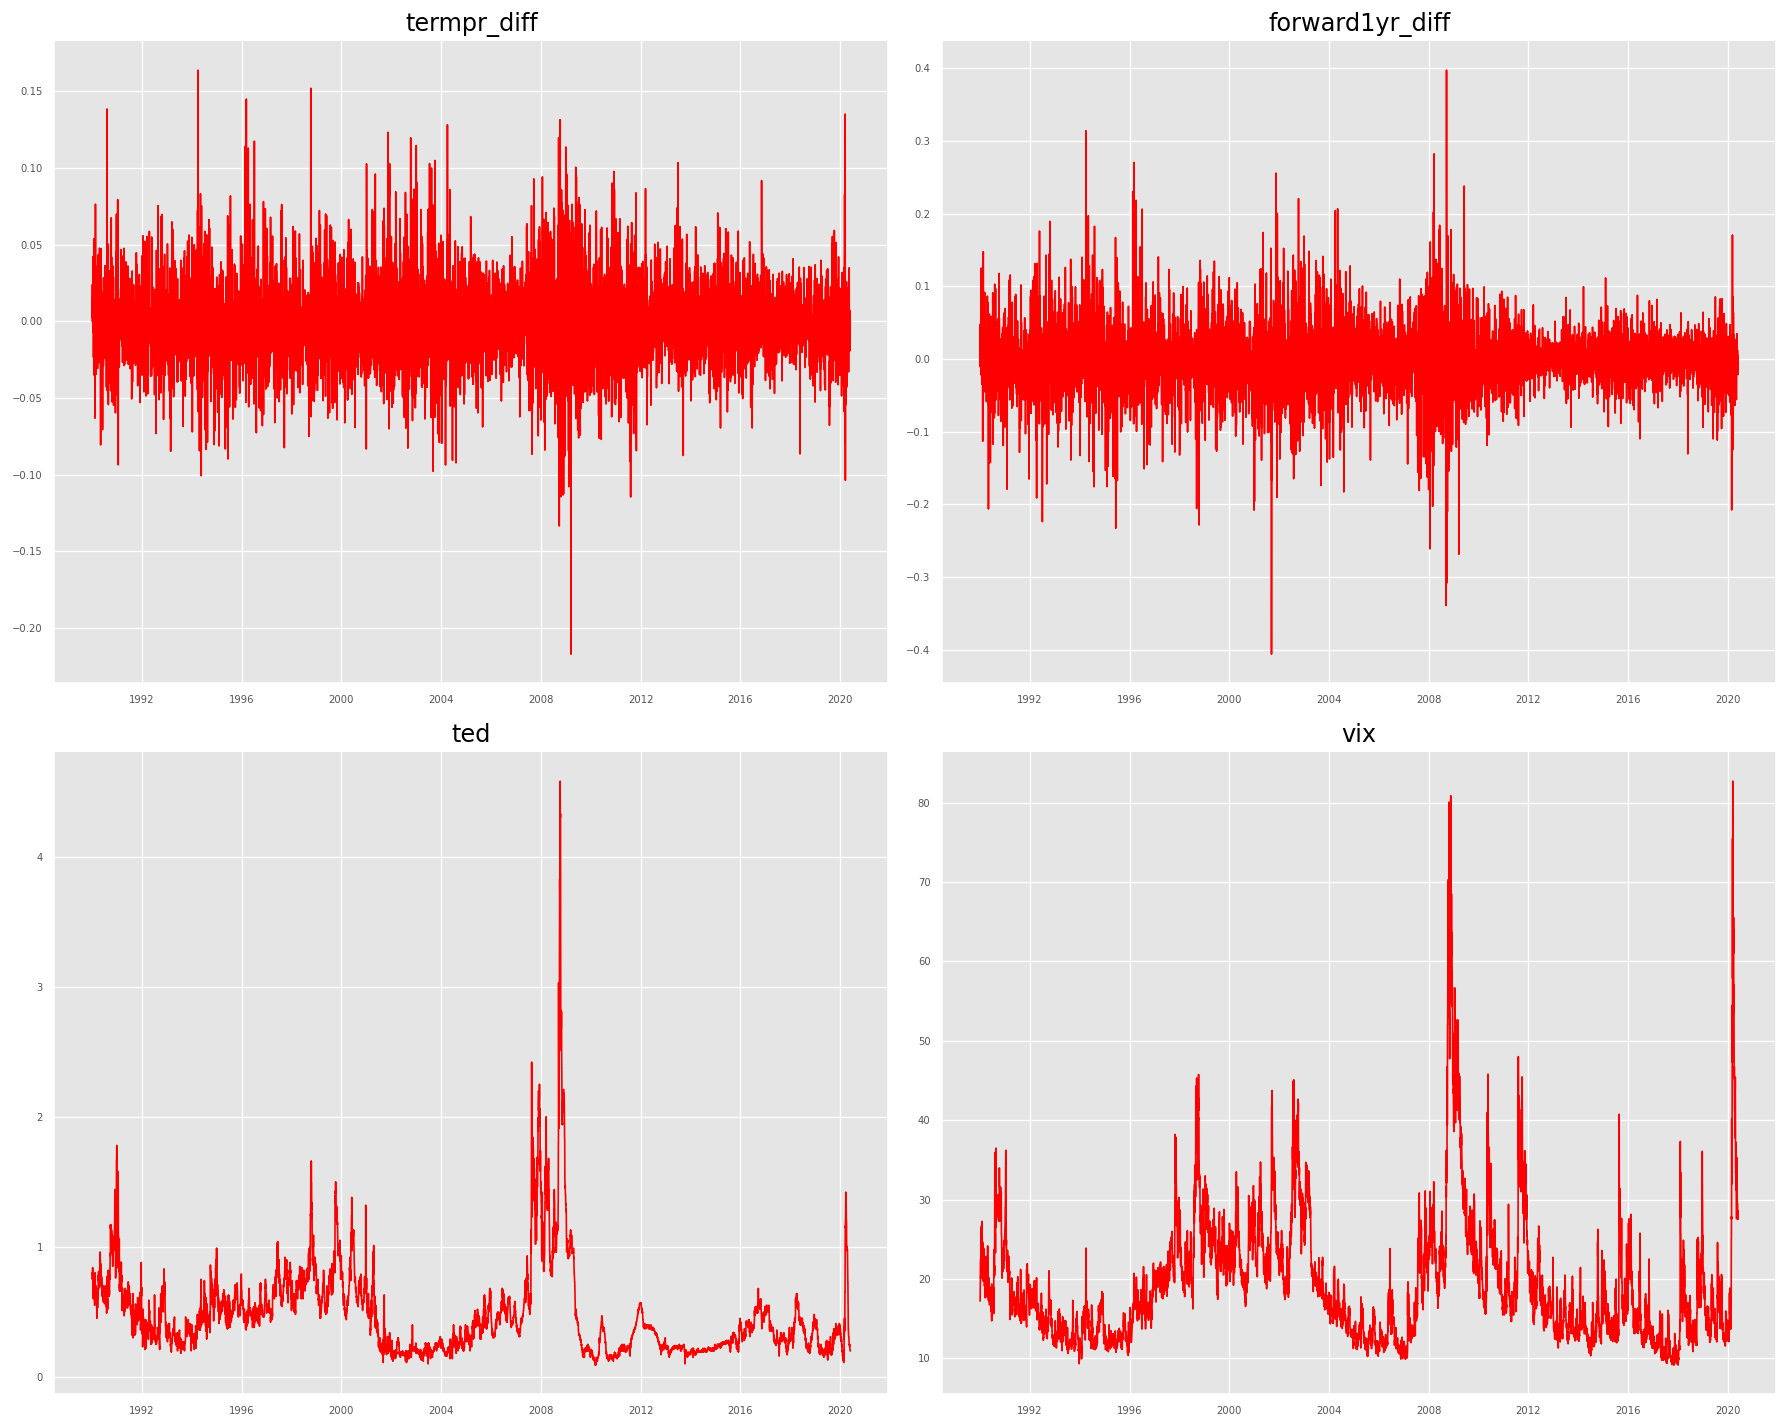

In [27]:
stat = stat1[['termpr_diff', 'forward1yr_diff', 'ted', 'vix']]

fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(15, 12))

for i, ax in enumerate(axes.flatten()):
    d = stat[stat.columns[i]]
    ax.plot(d, color='red', linewidth=1)
    
    # Decorations
    
    ax.set_title(stat.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines['top'].set_alpha(0)
    ax.tick_params(labelsize=6)
    plt.tight_layout();

## ARIMAX

The equation can have more than one exogenous variable and/or lags of exogenous variables in the above equation.

The dependent variable is a univariate time series.

The model cannot be used for forecasting 𝑦_𝑡+ℎ unless one has the future values of the independent variable 𝑥𝑡+ℎ 
available, or has a separate model for predicting 𝑥_𝑡+ℎ.

The model is estimated using maximum likelihood (slow), often using a state space representation.
Allowing for both AR and MA terms offers a parsimonious representation of the process.

In [28]:
# Train-test split : last 10 percent of the observations are in the test set
train, test = np.split(stat1, [int(.95 *len(stat1))])

#data_list = yield_d[list(yield_d.columns)]

exog_train = train[['ted', 'rec_ind', '1yr-ffr', 'vix', 'termpr_diff', 'forward1yr_diff']]
exog_test = test[['ted', 'rec_ind', '1yr-ffr', 'vix', 'termpr_diff','forward1yr_diff']]

# fit model in the train set

model = ARIMA(train['yieldsp'],exog = exog_train, order=(1,0,1)) 

# disp = 0: turns off the debug info about the fit of the ARIMA model
model_fit = model.fit(disp=0)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                yieldsp   No. Observations:                10553
Model:                     ARMA(1, 1)   Log Likelihood               20892.585
Method:                       css-mle   S.D. of innovations              0.033
Date:                Tue, 14 Jul 2020   AIC                         -41765.171
Time:                        09:22:48   BIC                         -41692.529
Sample:                    01-02-1990   HQIC                        -41740.648
                         - 11-23-2018                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2800      0.581      2.203      0.028       0.141       2.419
ted                 0.4672      0.008     57.530      0.000       0.451       0.483
rec_ind            -0.0098      

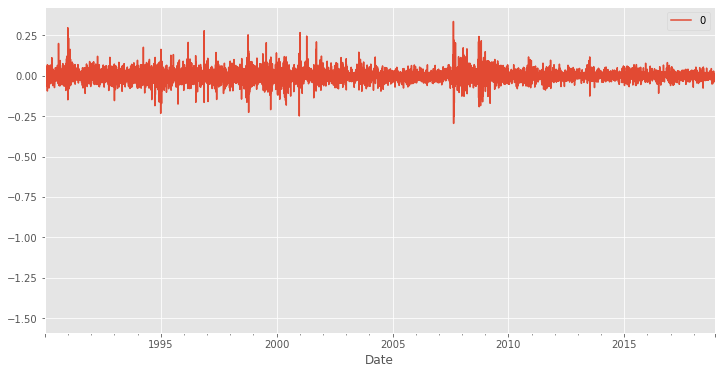

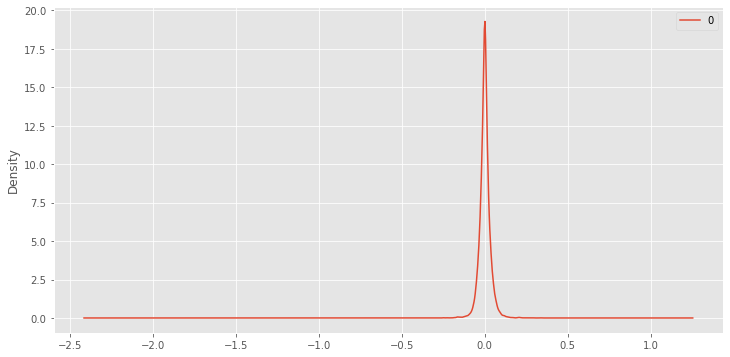

                  0
count  10553.000000
mean       0.000072
std        0.036452
min       -1.499083
25%       -0.015598
50%       -0.000237
75%        0.014792
max        0.335740


In [29]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()

# Density plot
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [30]:
# fit SARIMAX in the whole model, then compare forecats from the train with test set
exog = stat1[['ted', 'rec_ind', '1yr-ffr', 'vix', 'termpr_diff', 'forward1yr_diff']]

mod = sm.tsa.statespace.SARIMAX(stat1['yieldsp'], exog = exog,
                                order=(1, 0, 1),
                                seasonal_order=(0, 0, 0, 0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                yieldsp   No. Observations:                11109
Model:               SARIMAX(1, 0, 1)   Log Likelihood               19289.244
Date:                Tue, 14 Jul 2020   AIC                         -38560.489
Time:                        09:23:06   BIC                         -38494.651
Sample:                    01-02-1990   HQIC                        -38538.319
                         - 06-01-2020                                         
Covariance Type:                  opg                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
ted                 0.5354      0.004    151.060      0.000       0.528       0.542
rec_ind             0.0759      0.008     10.083      0.000       0.061       0.091
1yr-ffr             0.0344      

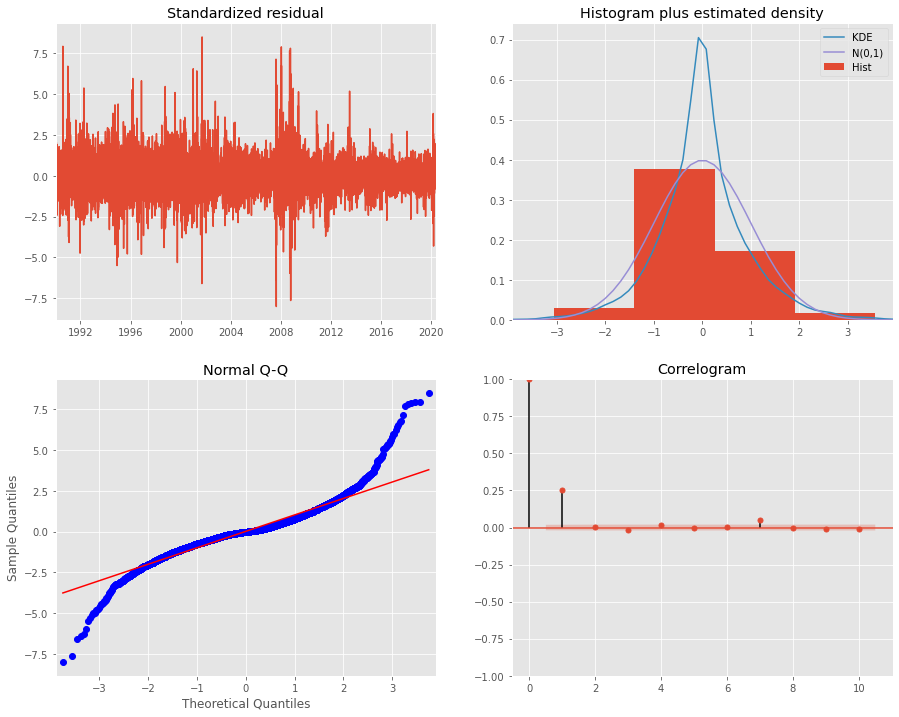

In [31]:
# run model diagnostics to ensure that none of the assumptions made by the model have been violated.
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [32]:
train.tail(1).index # last date on train set 

DatetimeIndex(['2018-11-23'], dtype='datetime64[ns]', name='Date', freq=None)

In [33]:
test.head(1).index # first date on test set

DatetimeIndex(['2018-11-24'], dtype='datetime64[ns]', name='Date', freq=None)

In [34]:
test.tail()

,ted,forward1yr,rec_ind,1yr-ffr,termpr,yieldsp,vix,sahm,forward1yr_diff,termpr_diff,yieldsp_diff,sahm_diff
Date,,,,,,,,,,,,
2020-05-28,0.2,0.2611,1.0,0.12,-0.8489,0.55,28.59,9.258933,0.0027,0.0034,0.02,0.062027
2020-05-29,0.2,0.2400,1.0,0.12,-0.8681,0.51,27.51,9.320238,-0.0211,-0.0192,-0.04,0.061305
2020-05-30,0.2,0.2393,1.0,0.12,-0.8703,0.52,28.23,9.380838,-0.0007,-0.0022,0.01,0.060600
2020-05-31,0.2,0.2393,1.0,0.12,-0.8703,0.52,28.23,9.440753,0.0000,0.0000,0.00,0.059914
2020-06-01,0.2,0.2393,1.0,0.12,-0.8703,0.52,28.23,9.500000,0.0000,0.0000,0.00,0.059247


In [35]:
# get predictions from the above model
#  compare predicted to real values of the time series => help us understand the accuracy of our forecasts
#  dynamic=False argument ensures that we produce one-step ahead forecasts, 
# => forecasts at each point are generated using the full history up to that point.
# compute the forecasts and confidence intervals start from the first date in the test set


pred_dynamic = results.get_prediction(start = pd.to_datetime('2018-11-24'), dynamic = True, 
                                      exog = exog_test, full_results = True)
                                      
pred_dynamic_ci = pred_dynamic.conf_int(exog = exog_test)
pred_dynamic_ci.head()

,lower yieldsp,upper yieldsp
2018-11-24,0.567754,0.733466
2018-11-25,0.549760,0.768660
2018-11-26,0.528272,0.789726
2018-11-27,0.503936,0.801902
2018-11-28,0.498035,0.828479


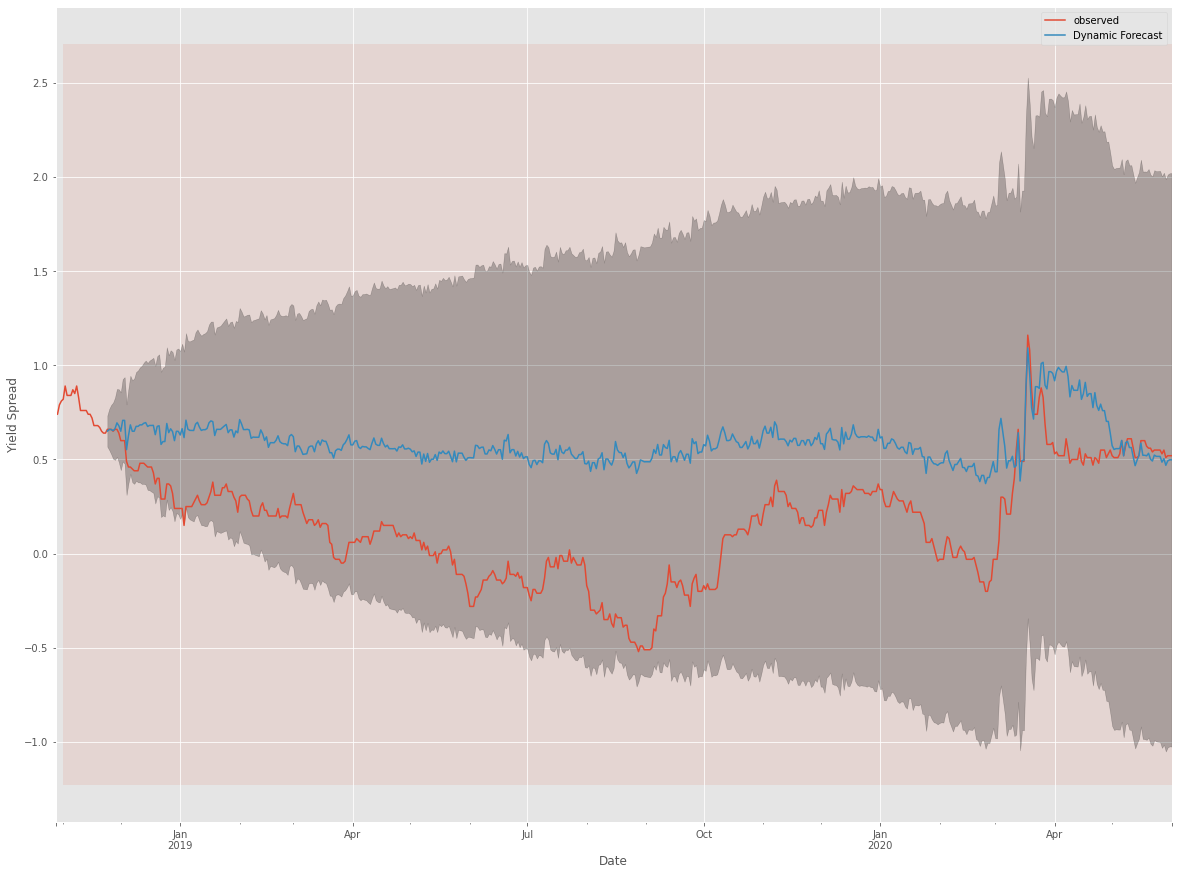

In [36]:
# plot the real and forecasted values of the yield spread 
# zoomed in on the end of the time series by slicing the date index.

ax = stat1['yieldsp']['2018-10-28':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax = ax)

# test set begins from 2012-09-30
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-11-01'), stat1['yieldsp'].index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('Yield Spread')

plt.legend()
plt.show()

In [39]:
y_forecasted = pred_dynamic.predicted_mean
y_truth = stat1['yieldsp']['2018-11-24':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

The Mean Squared Error of our forecasts is 0.244


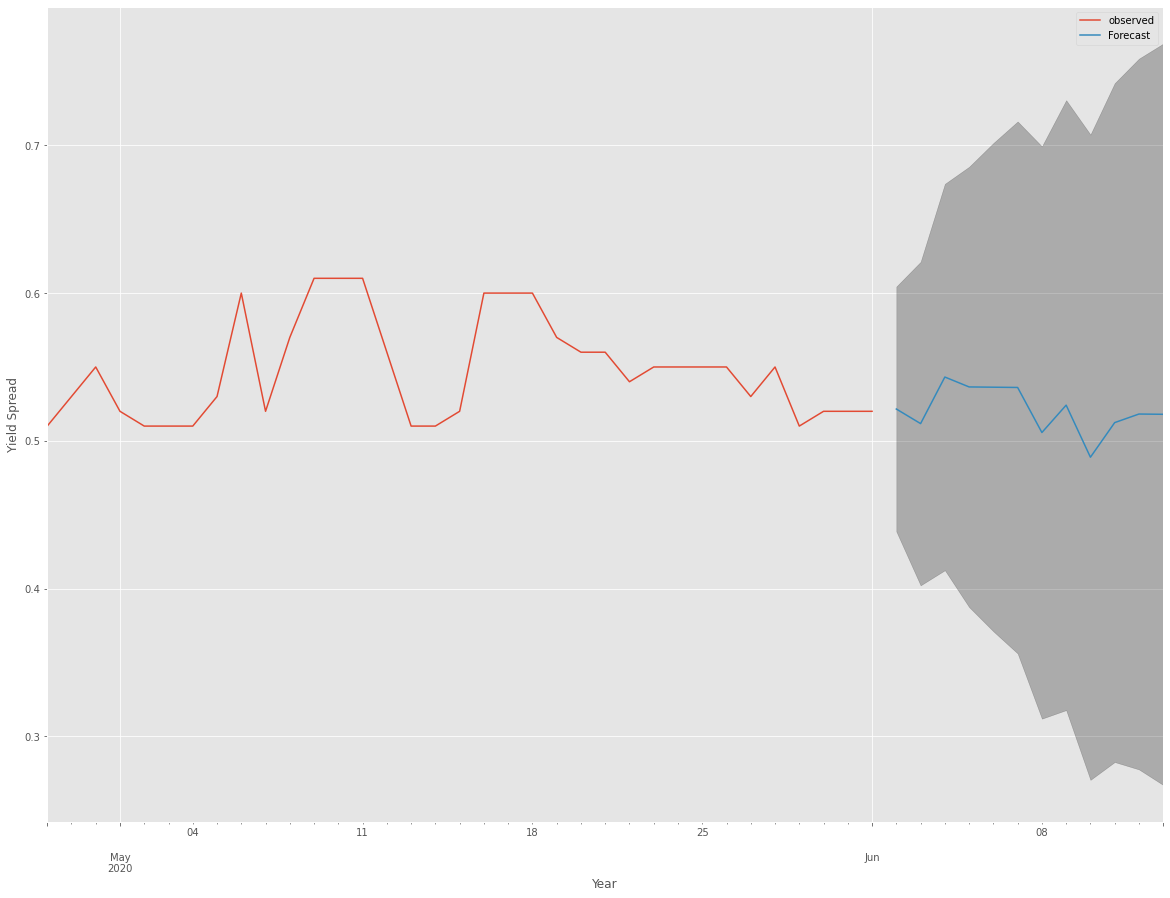

In [40]:
# Get forecast 12 steps ahead in future
pred_uc = results.get_forecast(steps= 12, exog = exog_test.tail(12))

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int(exog = exog_test.tail(12))

ax = stat1['yieldsp']['2020-04-28':].plot(label='observed', figsize=(20, 15))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Year')
ax.set_ylabel('Yield Spread')

plt.legend()
plt.show()

In [41]:
pred_ci

,lower yieldsp,upper yieldsp
2020-06-02,0.438699,0.604411
2020-06-03,0.402228,0.621128
2020-06-04,0.412467,0.673921
2020-06-05,0.387511,0.685477
2020-06-06,0.371093,0.701537
2020-06-07,0.356145,0.716128
2020-06-08,0.312023,0.699277
2020-06-09,0.317816,0.730524
2020-06-10,0.270601,0.707264
2020-06-11,0.282676,0.742029


In [44]:
# Does ted spread granger cause yield spread?
grangercausalitytests(stat1[['yieldsp', 'ted']], maxlag=5);


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3038  , p=0.0381  , df_denom=11105, df_num=1
ssr based chi2 test:   chi2=4.3049  , p=0.0380  , df=1
likelihood ratio test: chi2=4.3041  , p=0.0380  , df=1
parameter F test:         F=4.3038  , p=0.0381  , df_denom=11105, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.8641  , p=0.0010  , df_denom=11102, df_num=2
ssr based chi2 test:   chi2=13.7345 , p=0.0010  , df=2
likelihood ratio test: chi2=13.7260 , p=0.0010  , df=2
parameter F test:         F=6.8641  , p=0.0010  , df_denom=11102, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=14.7529 , p=0.0000  , df_denom=11099, df_num=3
ssr based chi2 test:   chi2=44.2867 , p=0.0000  , df=3
likelihood ratio test: chi2=44.1987 , p=0.0000  , df=3
parameter F test:         F=14.7529 , p=0.0000  , df_denom=11099, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=13.1844 

Since the p-values at lags from 1 to 5 lags are very low, we reject the null hypothesis. So, the ted spread Granger causes the yield spread. The p-values aee lower than the significance level even at lags greater than 5. So, the past values of ted spread  have a statistically significant effect on the current value of yield spread. Here, we consider the past values of ted spread as regressors.

In [45]:
# granger causality for all variables in the train set
stat_train = train[['termpr_diff', 'forward1yr_diff', 'ted', 'vix', 'yieldsp', 'yieldsp_diff', 'rec_ind']]

maxlag=5

test = 'ssr-chi2test'

def grangers_causality_matrix(data, variables, test = 'ssr_chi2test', verbose=False):

    dataset = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)

    for c in dataset.columns:
        for r in dataset.index:
            test_result = grangercausalitytests(data[[r,c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')

            min_p_value = np.min(p_values)
            dataset.loc[r,c] = min_p_value

    dataset.columns = [var + '_x' for var in variables]

    dataset.index = [var + '_y' for var in variables]

    return dataset

grangers_causality_matrix(stat_train, variables = stat_train.columns)  

,termpr_diff_x,forward1yr_diff_x,ted_x,vix_x,yieldsp_x,yieldsp_diff_x,rec_ind_x
termpr_diff_y,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0005
forward1yr_diff_y,0.0000,1.0000,0.0004,0.0002,0.0000,0.0000,0.0049
ted_y,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0038
vix_y,0.0205,0.0501,0.0000,1.0000,0.1118,0.0515,0.0000
yieldsp_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000
yieldsp_diff_y,0.0000,0.0000,0.0000,0.0000,0.0043,1.0000,0.0000
rec_ind_y,0.3623,0.4692,0.0002,0.0079,0.0424,0.0957,1.0000


The row are the response (y) and the columns are the predictor series (x).

p-value = 0.1118 => tests if yieldsp granger causes vix => since the p-value is larger than the 0.05 significance level, we fail to reject the null hypothesis => yieldsp does not granger causes vix

p-values = 0 under rows yieldsp and yieldsp_diff
since p-value = 0.0957 => fail to reject the null hypothesis => yield_diff doesn't granger cause rec_ind


## Vector Autoregression (VAR)

The dependent variable is a multivariate time series.

The model can be used for forecasting all components of 𝑧𝑡+ℎ, e.g. for 𝑧=(𝑦,𝑥)′. Given data up to and including time 𝑡, forecasts for time 𝑡+1 are straightforward to obtain; forecasts for 𝑡+ℎ where ℎ>1 can be obtained iteratively.

The model can be estimated using OLS or GLS (fast).

Lack of MA terms may (or may not) require large AR order to approximate the process well, and large AR order means a large number of parameters to be estimated and thus high estimation variance. Fortunately, regularization (shrinkage) applies pretty straightforwardly to VAR models (unlike ARMAX), so the variance can be tamed.

In [46]:
# use stationary variables only for VAR
stat_train = train[['yieldsp_diff','termpr_diff', 'forward1yr_diff', 'ted', 'vix', 'rec_ind']]

# fit the VAR model on training set and then used the fitted model to forecast the next 15 observations.
# compare these forecasts with the actual present in test data. 

mod = VAR(stat_train)
res = mod.fit(2) 
res.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 14, Jul, 2020
Time:                     09:28:24
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                   -36.4410
Nobs:                     10551.0    HQIC:                  -36.4766
Log likelihood:           102779.    FPE:                1.41430e-16
AIC:                     -36.4947    Det(Omega_mle):     1.40389e-16
--------------------------------------------------------------------
Results for equation yieldsp_diff
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.001068         0.001507           -0.708           0.479
L1.yieldsp_diff            0.165437         0.021193            7.806           0.000
L1.termpr_diff            -0.1976

## Durbin-Watson Statistic

Durbin-Watson Statistic is related to related to auto correlation.

The Durbin-Watson statistic will always have a value between 0 and 4. A value of 2.0 means that there is no auto-correlation detected in the sample. Values from 0 to less than 2 indicate positive auto-correlation and values from 2 to 4 indicate negative auto-correlation. A rule of thumb is that test statistic values in the range of 1.5 to 2.5 are relatively normal. Any value outside this range could be a cause for concern.

In [47]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(res.resid)

for col, val in zip(stat_train.columns, out):
    print((col), ':', round(val, 2))

yieldsp_diff : 2.0
termpr_diff : 2.0
forward1yr_diff : 2.0
ted : 2.0
vix : 2.0
rec_ind : 2.0


Since there is no auto-correlation (2.0); then, we can forecast. 

## Prediction

In order to forecast, the VAR model expects up to the lag order number of observations from the past data. This is because, the terms in the VAR model are essentially the lags of the various time series in the data-set, so we need to provide as many of the previous values as indicated by the lag order used by the model.

In [48]:
# Get the lag order
lag_order = res.k_ar
print(lag_order)

# Train-test split : last 10 percent of the observations are in the test set (from before)
train, test = np.split(stat1, [int(.95 *len(stat1))])

stat_test = test[['yieldsp_diff','termpr_diff', 'forward1yr_diff', 'ted', 'vix', 'rec_ind']]


# Input data for forecasting
input_data = stat_test.values[-lag_order:]
print(input_data)

# VAR forecasts for the test set
pred = res.forecast(y=input_data, steps = len(test))
pred1 = pd.DataFrame(pred, index=stat_test.index, columns= stat_test.columns + '_pred')
pred1.head()

2
[[ 0.    0.    0.    0.2  28.23  1.  ]
 [ 0.    0.    0.    0.2  28.23  1.  ]]


,yieldsp_diff_pred,termpr_diff_pred,forward1yr_diff_pred,ted_pred,vix_pred,rec_ind_pred
Date,,,,,,
2018-11-24,0.010967,0.001336,-0.001120,0.205645,28.160435,0.995021
2018-11-25,0.012161,0.001840,-0.002071,0.212063,28.101757,0.990131
2018-11-26,0.011808,0.002105,-0.002102,0.218094,28.040311,0.985279
2018-11-27,0.011523,0.002150,-0.002145,0.223915,27.979847,0.980448
2018-11-28,0.011385,0.002138,-0.002203,0.229616,27.920925,0.975650


In [49]:
merge = pd.merge(test, pred1['yieldsp_diff_pred'].to_frame(), how='inner', left_index=True, right_index=True)

# inverting transformation
def invert_diff(history, yhat, interval=1):
    return yhat + history[-interval]

invert = invert_diff(merge['yieldsp'], merge['yieldsp_diff_pred'], 1).to_frame()
invert.rename(columns={'yieldsp_diff_pred':'invert_yieldsp'}, inplace=True)
merge_invert = pd.merge(merge, invert, how='inner', left_index=True, right_index=True)
merge_invert.tail()

,ted,forward1yr,rec_ind,1yr-ffr,termpr,yieldsp,vix,sahm,forward1yr_diff,termpr_diff,yieldsp_diff,sahm_diff,yieldsp_diff_pred,invert_yieldsp
Date,,,,,,,,,,,,,,
2020-05-28,0.2,0.2611,1.0,0.12,-0.8489,0.55,28.59,9.258933,0.0027,0.0034,0.02,0.062027,0.000864,0.520864
2020-05-29,0.2,0.2400,1.0,0.12,-0.8681,0.51,27.51,9.320238,-0.0211,-0.0192,-0.04,0.061305,0.000862,0.520862
2020-05-30,0.2,0.2393,1.0,0.12,-0.8703,0.52,28.23,9.380838,-0.0007,-0.0022,0.01,0.060600,0.000859,0.520859
2020-05-31,0.2,0.2393,1.0,0.12,-0.8703,0.52,28.23,9.440753,0.0000,0.0000,0.00,0.059914,0.000857,0.520857
2020-06-01,0.2,0.2393,1.0,0.12,-0.8703,0.52,28.23,9.500000,0.0000,0.0000,0.00,0.059247,0.000854,0.520854


In [50]:
error = mean_squared_error(merge_invert['yieldsp'], merge_invert['invert_yieldsp'])
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 0.494


In [51]:
# line plot shows the expected values (red) compared to the rolling forecast predictions (blue).
test_df = go.Scatter(x = merge_invert.index, y = merge_invert['yieldsp'], line=dict(color='red', width= 1))

layout = go.Layout(title='Yield Spread (10 Year - 2 Month Treasury Rate)', 
                   title_font_size=15, 
                   xaxis_title="Years", yaxis_title="Yield Spread", 
                   xaxis_range=[datetime.datetime(2019, 3, 8),
                   datetime.datetime(2020, 7, 1)])

pred_df = go.Scatter(x = merge_invert.index,
                        y = merge_invert['invert_yieldsp'],
                        line=dict(color='blue', width= 1),
                        opacity=1,
                        name='Predictions',
                        yaxis='y2')


# Create a layout with two yaxes
layout = go.Layout(height=600, width=1000, font=dict(size=15),
                   title='Actual and Predicted Yield Spread from VAR',
                   xaxis=dict(title='Date', type='date'),
                   
                   yaxis=dict(title='Test', color='red'),
                   # Add a second yaxis to the right of the plot
                   yaxis2=dict(title='Predicted', color='blue',
                                          overlaying='y',
                                          side='right'),
                   xaxis_range=[datetime.datetime(2018, 11, 24),
                   datetime.datetime(2020, 6, 1)]
                   )

fig = go.Figure(data=[test_df, pred_df], layout=layout)
iplot(fig)

In [350]:
# Evaluation: # forecast period is 5 year=> forecasting upto 5 years into the future
fevd = res.fevd(5)
fevd.summary()

FEVD for yieldsp_diff
     yieldsp_diff  termpr_diff  forward1yr_diff       ted       vix   rec_ind
0        1.000000     0.000000         0.000000  0.000000  0.000000  0.000000
1        0.996048     0.002961         0.000019  0.000091  0.000601  0.000280
2        0.995755     0.002981         0.000217  0.000132  0.000618  0.000298
3        0.995567     0.003062         0.000279  0.000148  0.000633  0.000311
4        0.995501     0.003076         0.000285  0.000165  0.000650  0.000324

FEVD for termpr_diff
     yieldsp_diff  termpr_diff  forward1yr_diff       ted       vix   rec_ind
0        0.574327     0.425673         0.000000  0.000000  0.000000  0.000000
1        0.584110     0.412947         0.001545  0.000002  0.001090  0.000307
2        0.585546     0.411113         0.001874  0.000008  0.001127  0.000332
3        0.585567     0.411040         0.001911  0.000012  0.001129  0.000341
4        0.585560     0.411036         0.001913  0.000014  0.001130  0.000347

FEVD for forward1yr

Variance decomposition shows how much a shock to one variable (e.g: vix, ted, etc) impacts the variance of the forecast error of a different one (e.g: forward1yr, rec_ind, yieldsp, etc). So, in the short run, i.e. in the same period, the yieldsp_diff  explains 57.43% of the variance in forecast error of termpr_diff,indicating that it is strongly endogenous as it has a strong influence on termpr_diff.  ted, vix, rec_ind are strongly exogenous as they only weakly influence in predicting the termpr_diff in the present. termpr_diff itself explains 42.56 percent of variance in the its error.

However, in the long run, the influence of termpr_diff in explaining the variance in its forecast error has diminished marginally from 42.56 to 41.1 percent, whereas yieldsp_diff and fed_fundsR has an incremental influence, as its affect rises from 57.43 to 58.5 percent in the short in the earlier periods in the short run.

## Impulse Response Functions

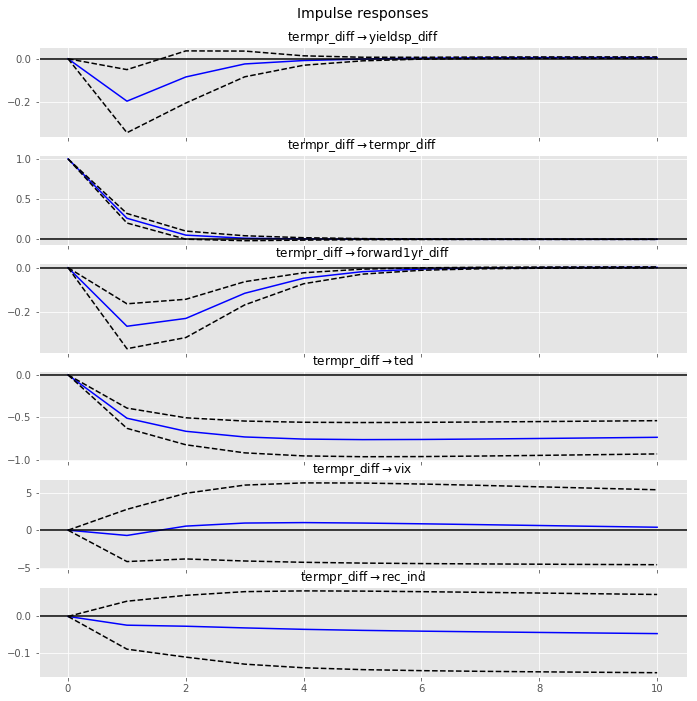

In [351]:
irf1 = res.irf(10)
irf1.plot(impulse='termpr_diff');

## VARMAX

VAR(2) and VARMAX(2, 0) are theoretically identical models, however in statsmodels the VAR(2) model is fit via conditional maximum likelihood (i.e. least squares) and the VARMAX(2, 0) model is fit via exact maximum likelihood.

You will generally not get the same coefficients, for two reasons:
(1) Conditional MLE is only asymptotically the same as exact MLE
(2) The maximum likelihood estimates in VARMAX are found numerically, and there may be difficulties finding the maximum and / or there may be numerical noise.

Convergence warnings in VARMAX are common, because vector autoregressions typically have poor identification for many of the parameters.

Advantage - VARMA is closed w.r.t linear transformation => linear transformation finite order VARMA has a finite order VARMA representation.
https://core.ac.uk/download/pdf/6263631.pdf


In [414]:
range(3)

range(0, 3)

In [416]:
for p in range(1,3):
    for q in range(1,3):
        p += 1
        q += 1
        order = (p,q)
        model = sm.tsa.VARMAX(stat_train, order= order)
        model_result = model.fit(maxiter=100, disp=False)
        print('Order = ', order)
        print('AIC: ', model_result.aic)

Order =  (2, 2)
AIC:  -205504.94432127534
Order =  (3, 3)
AIC:  -206081.03950521542
Order =  (3, 2)
AIC:  -205958.43455329948
Order =  (4, 3)
AIC:  -206204.543292884


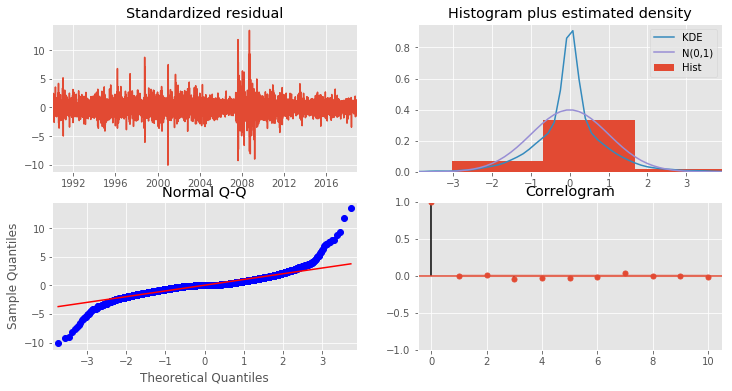

In [422]:
model = sm.tsa.VARMAX(stat_train, order=(2, 2))
model_result = model.fit(maxiter=100, disp=False)
model_result.plot_diagnostics()
plt.show()

In [423]:
vfor = model_result.forecast(steps=len(test))
varmax_forecast = pd.DataFrame(vfor['yieldsp_diff']).rename(columns={'yieldsp_diff':'yieldsp_diff_pred'})

In [424]:
invert1 = invert_diff(test['yieldsp'], varmax_forecast['yieldsp_diff_pred'], 1).to_frame()
invert1.rename(columns={'yieldsp_diff_pred':'invert_yieldsp'}, inplace=True)
merge_invert1 = pd.merge(test['yieldsp'].to_frame(), invert1, how='inner', left_index=True, right_index=True)
merge_invert1.tail()

,yieldsp,invert_yieldsp
Date,,
2020-05-28,0.55,0.519217
2020-05-29,0.51,0.519217
2020-05-30,0.52,0.519217
2020-05-31,0.52,0.519217
2020-06-01,0.52,0.519217


In [425]:
error = mean_squared_error(merge_invert1['yieldsp'], merge_invert1['invert_yieldsp'])
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

RMSE: 0.896


In [426]:
# line plot shows the expected values (red) compared to the rolling forecast predictions (blue).
test_df = go.Scatter(x = merge_invert1.index, y = merge_invert1['yieldsp'], line=dict(color='red', width= 1))

layout = go.Layout(title='Yield Spread (10 Year - 2 Month Treasury Rate)', 
                   title_font_size=15, 
                   xaxis_title="Years", yaxis_title="Yield Spread", 
                   xaxis_range=[datetime.datetime(2019, 3, 8),
                   datetime.datetime(2020, 7, 1)])

pred_df = go.Scatter(x = merge_invert1.index,
                        y = merge_invert1['invert_yieldsp'],
                        line=dict(color='blue', width= 1),
                        opacity=1,
                        name='Predictions',
                        yaxis='y2')


# Create a layout with two yaxes
layout = go.Layout(height=600, width=1000, font=dict(size=15),
                   title='Actual and Predicted Yield Spread from VARMAX',
                   xaxis=dict(title='Date', type='date'),
                   
                   yaxis=dict(title='Test', color='red'),
                   # Add a second yaxis to the right of the plot
                   yaxis2=dict(title='Predicted', color='blue',
                                          overlaying='y',
                                          side='right'),
                   xaxis_range=[datetime.datetime(2018, 11, 24),
                   datetime.datetime(2020, 6, 1)]
                   )

fig = go.Figure(data=[test_df, pred_df], layout=layout)
iplot(fig)

In [66]:
train.head()

,ds,ted,forward1yr,rec_ind,1yr-ffr,termpr,y,vix,sahm
0,1990-01-01,0.80,7.8401,0.0,-0.73,1.6625,0.11,17.24,0.130000
1,1990-01-02,0.80,7.8401,0.0,-0.73,1.6625,0.11,17.24,0.130696
2,1990-01-03,0.75,7.8880,0.0,-0.52,1.6865,0.10,18.19,0.131360
3,1990-01-04,0.79,7.8773,0.0,-0.47,1.6890,0.14,19.22,0.131991
4,1990-01-05,0.84,7.8694,0.0,-0.41,1.7017,0.20,20.11,0.132587


In [67]:
import utils

ModuleNotFoundError: No module named 'utils'

In [65]:
yield_d1 = yield_d.reset_index().rename(columns={'Date':'ds', 'yieldsp':'y'})
pred_size = 30

# define the train set => hold iut the last 30 wentries for prediction and validation
train = yield_d1[:-pred_size]

m = Prophet()
m.add_regressor('ted', prior_scale=0.5, mode='multiplicative')
m.add_regressor('forward1yr', prior_scale=0.5, mode='multiplicative')
m.add_regressor('red_ind', prior_scale=0.5, mode='multiplicative')
m.add_regressor('1yr-ffr', prior_scale=0.5, mode='multiplicative')
m.add_regressor('vix', prior_scale=0.5, mode='multiplicative')
m.add_regressor('sahm', prior_scale=0.5, mode='multiplicative')

m.fit(train)
future = m.make_future_dataframe(periods= pred_size)
futures = utils.add_regressor_to_future(future, [ted,forward1yr, red_ind, 1yr-ffr, vix, sahm ])

forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(15)

ValueError: Regressor "sahm" missing from dataframe

In [ ]:
train_dataset[‘type’] = X['type']
train_dataset[‘Total Volume’] = X[‘Total Volume’]
train_dataset[‘4046’] = X[‘4046’]
train_dataset[‘4225’] = X[‘4225’]
train_dataset[‘4770’] = X[‘4770’]
train_dataset[‘Small Bags’] = X[‘Small Bags’]
train_X= train_dataset[:18000]
test_X= train_dataset[18000:]

In [ ]:
#Additional Regressor
pro_regressor= Prophet()
pro_regressor.add_regressor('type')
pro_regressor.add_regressor('Total Volume')
pro_regressor.add_regressor('4046')
pro_regressor.add_regressor('4225')
pro_regressor.add_regressor('4770')
pro_regressor.add_regressor('Small Bags')
#Fitting the data
pro_regressor.fit(train_X)
future_data = pro_regressor.make_future_dataframe(periods=249)
#forecast the data for Test  data
forecast_data = pro_regressor.predict(test_X)
pro_regressor.plot(forecast_data);